# 1.4 Perspective Projection, 2-D

1) Write some code that simulates the projection of a line segment defined by two points (-5,Z) and (5,Z), where Z ranges from 10 to 1000, and assuming a camera focal length of f=1.

2) For each distance Z, project the two points into a 1-D sensor under perspective projection, and compute the length of the segment.

3) Plot this length as a function of distance Z to see how size changes as a function of distance to the camera.


In [1]:
import matplotlib.pyplot as plt

def convert_world_to_sensor_2d(Z:float, X:float = 5., f:float = 1.) -> float:
    """ Convert world coordinates to sensor coordinates. solves for x in the equation Z = f*X/Z """
    return -1*(f*X)/Z

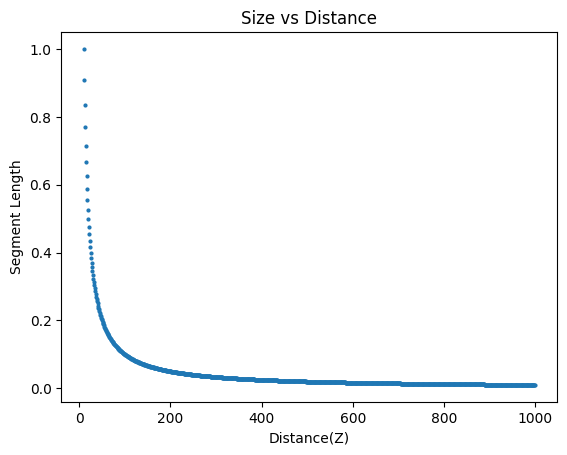

In [2]:
Z_range = range(10, 1000, 1)
segment_lengths = []
for Z in Z_range:
    sensor_coord_1 = convert_world_to_sensor_2d(Z, -5)
    sensor_coord_2 = convert_world_to_sensor_2d(Z, 5)
    segment_length = abs(sensor_coord_1 - sensor_coord_2)
    segment_lengths.append(segment_length)

plt.scatter(Z_range, segment_lengths, s=4)
plt.xlabel('Distance(Z)')
plt.ylabel('Segment Length')
plt.title('Size vs Distance')
plt.show()

## TAKEAWAY
- even though the size of the line segment in the world does not change (always equals 10), the line segment projected onto the image sensor gets smaller as the diatance X to aperture gets larger.
- However, the size changes more quickly when close to aperture than it does when really far away. 

_______
# 1.7 Perspective Projection, 3-D

1) Write some code that simulates the projection of a 3-D cube under perspective projection. The eight corners of the cube are:
    [0,0,0], [1,0,0], [1,1,0], [0,1,0], [0,0,1], [1,0,1], [1,1,1], [0,1,1]

2) Specify the translation and rotation around the x-, y-, and z-axis and build the 3x4 extrinsic matrix M. Specify the focal length and camera center, and build the 3x3 intrinsic matrix K.

3) Project under perspective projection using the projection matrix formulation:


4) Draw the resulting "Image"


In [3]:
import numpy as np
from math import sin, cos
import matplotlib.pyplot as plt


def perspective_projection_3d_to_2d(   
    points_in_3D: np.ndarray = np.array([[-1, -1, -1],
                                        [ 1, -1, -1],
                                        [ 1,  1, -1],
                                        [-1,  1, -1],
                                        [-1, -1,  1],
                                        [ 1, -1,  1],
                                        [ 1,  1,  1],
                                        [-1,  1,  1]]),
    focal_length: float = 1.,
    rotation_xyz: list[float] = [0., 0., 10.],
    transpose_xyz: list[float] = [0., 0., 0.],
    camera_offset_xy: list[float] = [0., 0.]
) -> np.ndarray:
    """ Perform perspective projection from 3D to 2D.

    Args:
        focal_length (float): focal length of the camera
        rotation_xyz (list[float]): rotation angles in all 3 directions
        transpose_xyz (list[float]): translation in all 3 directions
        camera_offset_xy (list[float]): camera center offset in x and y directions
    
    Returns:
        np.ndarray: (x,y) coordinates for each point projected into 2D
    """


    # convert 3D to homogenous coordinate matrix
    P = np.hstack([points_in_3D, np.ones((points_in_3D.shape[0], 1))])

    # ------------------------------------------------------------------
    # rotation angles in all 3 directions
    Rx = np.radians(rotation_xyz[0])
    Ry = np.radians(rotation_xyz[1])
    Rz = np.radians(rotation_xyz[2])

    # World translation relative to pinhole in all 3 directions 
    Tx = transpose_xyz[0]
    Ty = transpose_xyz[1]
    Tz = transpose_xyz[2]

    # focal length (often this is something like 30 mm, 20 mm, etc.)
    f = focal_length

    # camera center
    cx = camera_offset_xy[0]
    cy = camera_offset_xy[1]

    # ------------------------------------------------------------------
    # DEFINE THE 3x3 INTRINSIC MATRIX, K
    K = np.array(
        [[f, 0, cx],
        [0, f, cy],
        [0, 0,  1]]
    )

    # ------------------------------------------------------------------
    # Build the 3x4 extrinsic matrix, M
    rotation_mat_x = np.array(
        [[1,       0,        0],
        [0, cos(Rx), -sin(Rx)],
        [0, sin(Rx),  cos(Rx)]]
    )

    rotation_mat_y = np.array(
        [[ cos(Ry), 0, sin(Ry)],
        [       0, 1,       0],
        [-sin(Ry), 0, cos(Ry)]]
    )
    rotation_mat_z = np.array(
        [[cos(Rz), -sin(Rz), 0],
        [sin(Rz),  cos(Rz), 0],
        [      0,        0, 1]]
    )

    # combine the rotation transformation into a single matrix
    RM = rotation_mat_x @ rotation_mat_y @ rotation_mat_z

    # Define the translation matrix, TM, and 
    TM = np.array(
        [[Tx],
        [Ty],
        [Tz]]
    )
    # combine RM and TM to create the extrinsic matrix M
    M = np.hstack([RM, TM])

    p = K @ M @ P.T

    # convert from homogenous to 2D cartesian coordinates
    # s is the third row of projection matrix
    s = p[2, :]
    p /= s

    # drop the third row, Transpose to convert back into a set of 8 (x,y) coords in 2D
    p = p[:2, :]
    p = p.T

    # show the resulting points
    return p


def plot_matrix(points: np.ndarray):
    """ Plot the 2D projection. """
    plt.figure(figsize=(6,6))
    plt.scatter(points[:,0], points[:,1], c='r')

    # Emphasize X and Y axis
    plt.axvline(0, color='gray')
    plt.axhline(0, color='gray')

    # Define the indices of the corners that should be connected with lines
    line_indices = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
        (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
        (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges
    ]

    # Connect the corners of the bottom face with green lines
    for i, j in line_indices:
        plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'b-')
    for i, j in line_indices[:4]:
        plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'g-')


    # Decorate Chart
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D Projection of 3D Cube')
    plt.grid(True)

    # Adjust axes to center (0,0) and scale to fit the projected points
    s=1.4
    max_x = points[:,0].max() * s
    min_x = points[:,0].min() * s
    max_y = points[:,1].max() * s
    min_y = points[:,1].min() * s
    plt.gca().set_xlim([min_x, max_x])
    plt.gca().set_ylim([min_y, max_y])

    plt.show()
    # return plt.gcf()



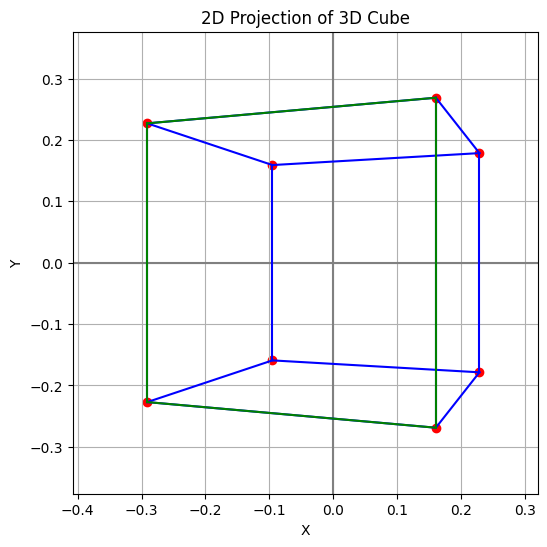

In [4]:
# Define the world coordinates for all corners of the 3-D unit cube (homogeneous coordinates)

projected_points = perspective_projection_3d_to_2d(
    focal_length = 1.,
    rotation_xyz = [0., 20., 0.], 
    transpose_xyz = [0, 0., 5.], 
    camera_offset_xy = [0., 0.]
)

# Connect the corners of the bottom face with green lines
plot_matrix(projected_points)


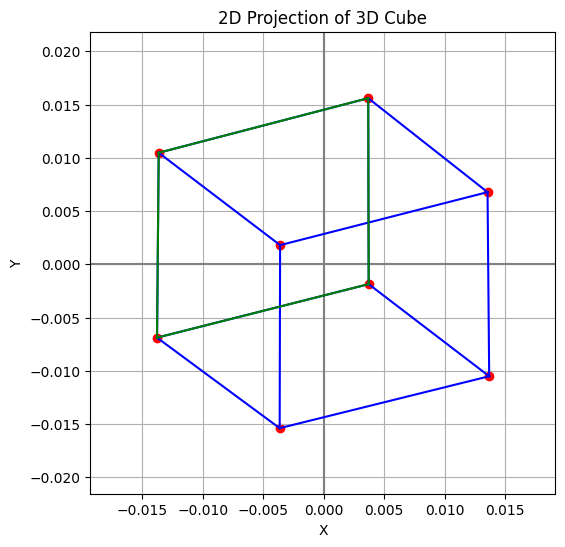

In [5]:
# Define the world coordinates for all corners of the 3-D unit cube (homogeneous coordinates)
corners_3d = np.array(
    [[-1, -1, -1],
    [ 1, -1, -1],
    [ 1,  1, -1],
    [-1,  1, -1],
    [-1, -1,  1],
    [ 1, -1,  1],
    [ 1,  1,  1],
    [-1,  1,  1]]
)
projected_points = perspective_projection_3d_to_2d(
    points_in_3D = corners_3d, 
    focal_length = 1.0,
    rotation_xyz = [30., 30., 0.], 
    transpose_xyz = [0., 0., 100.], 
    camera_offset_xy = [0., 0.]
)

plot_matrix(projected_points)

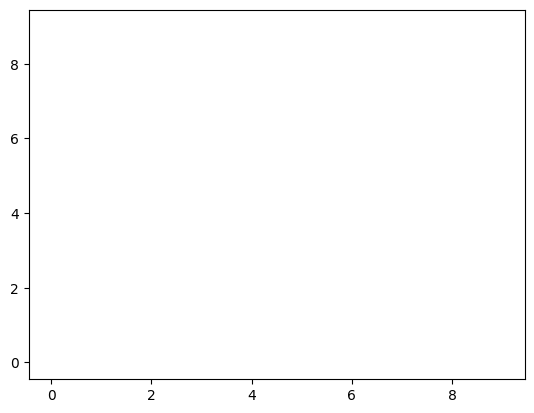

In [9]:
from matplotlib import pyplot as plt
from celluloid import Camera

fig = plt.figure()
camera = Camera(fig)
for i in range(10):
    plt.plot([i] * 10)
    camera.snap()
animation = camera.animate()

animation.save(
    'complex.mp4',
    dpi=100,
)

<Figure size 640x480 with 0 Axes>

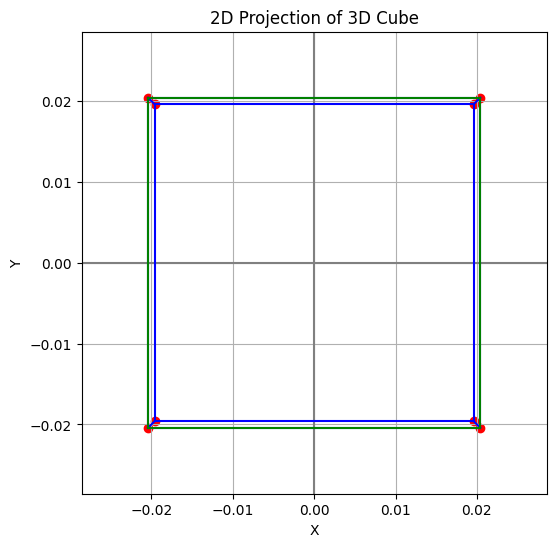

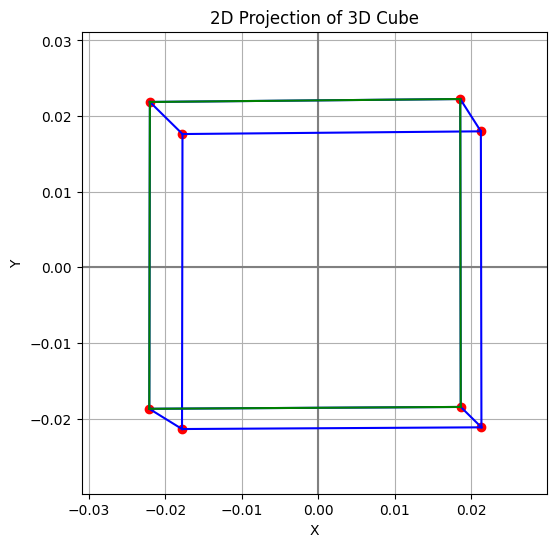

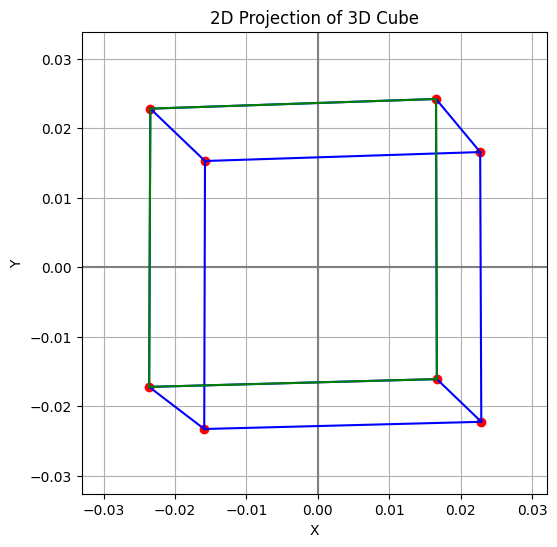

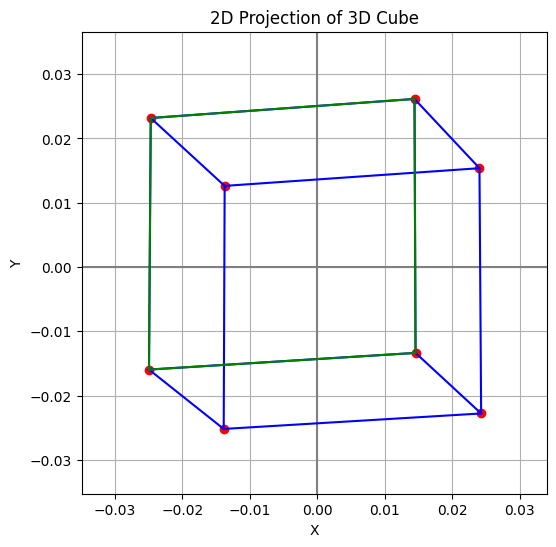

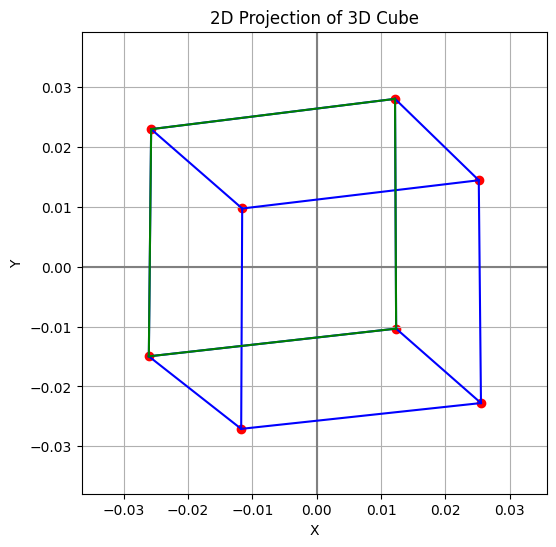

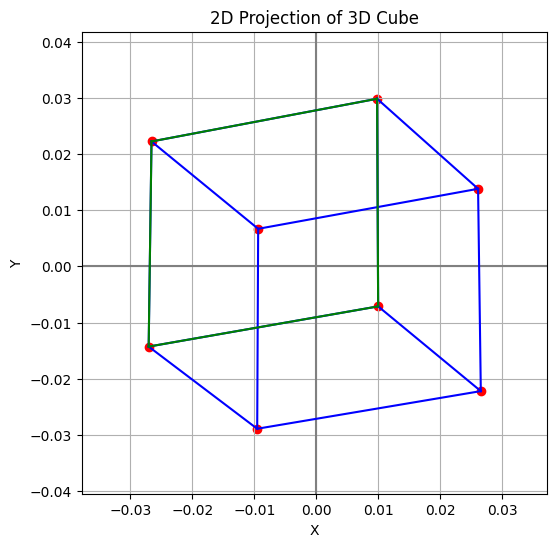

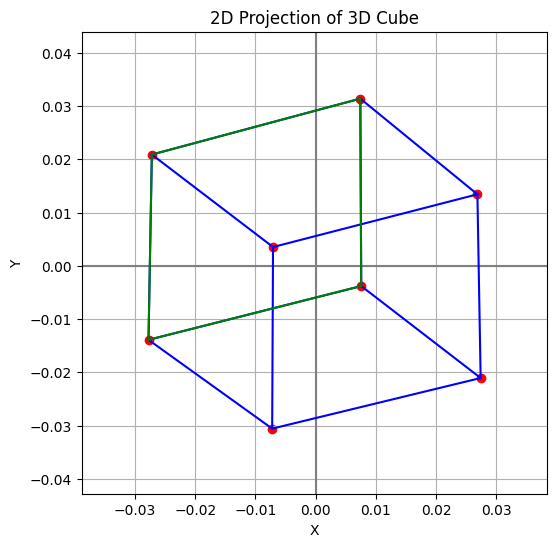

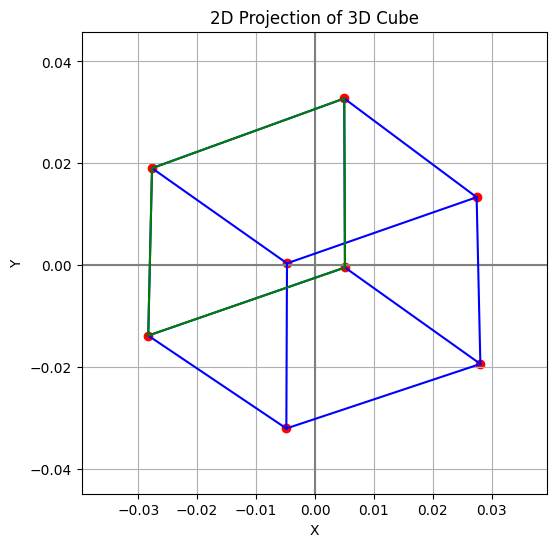

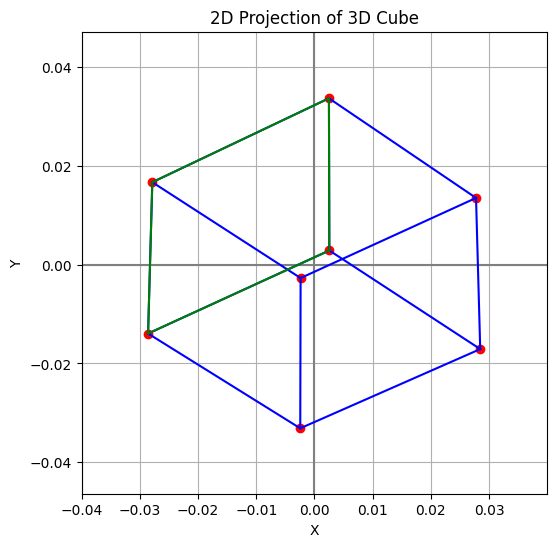

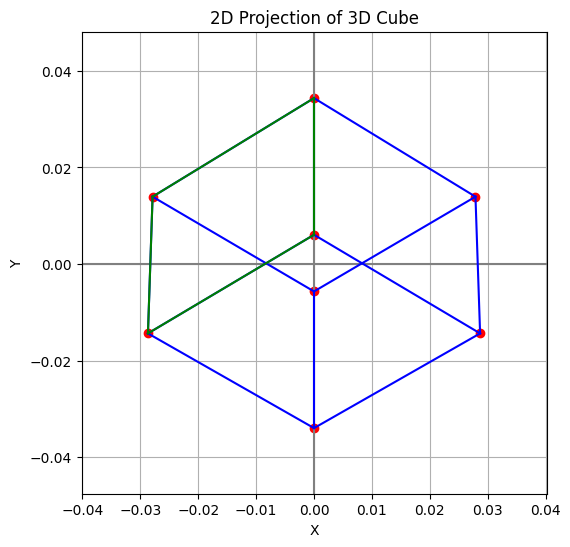

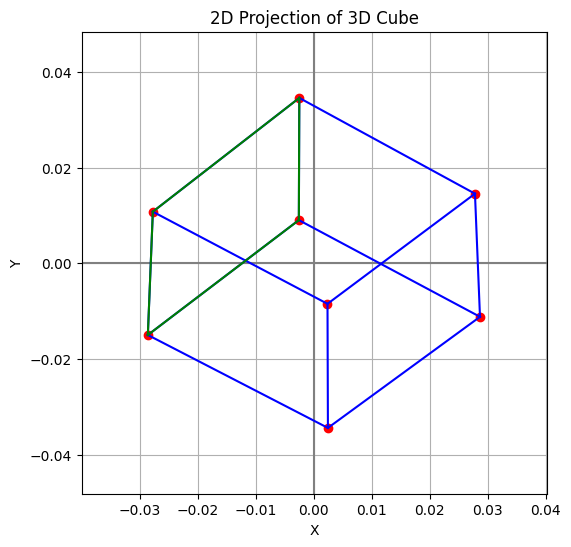

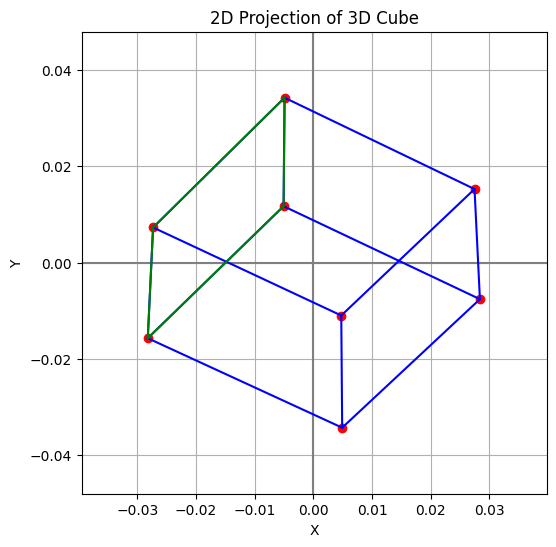

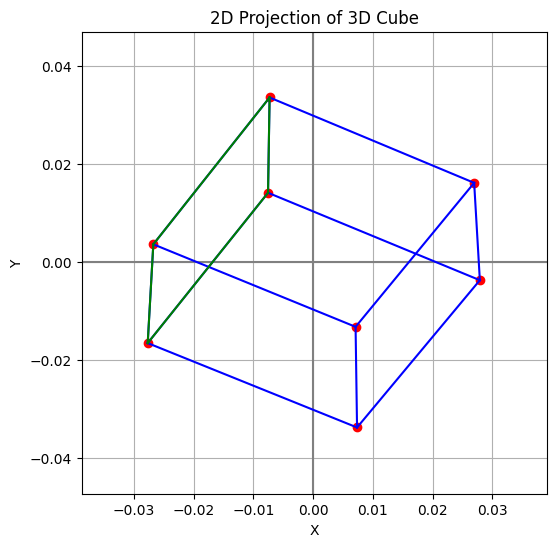

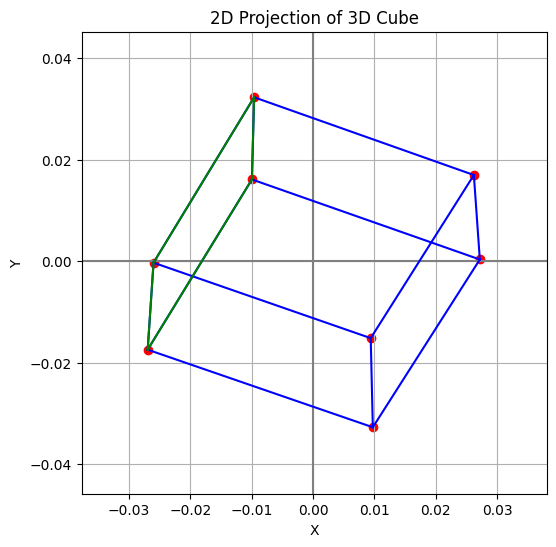

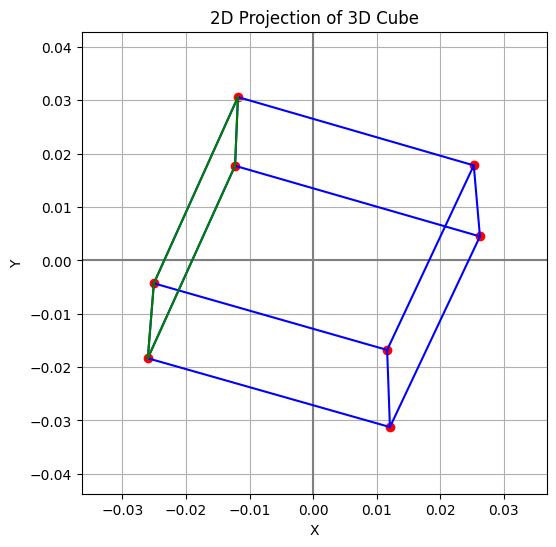

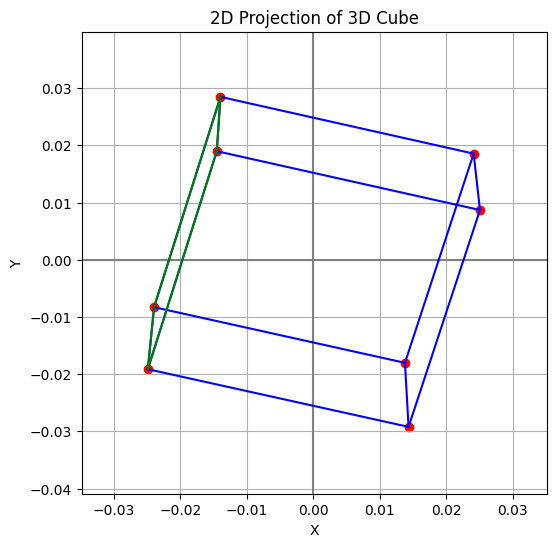

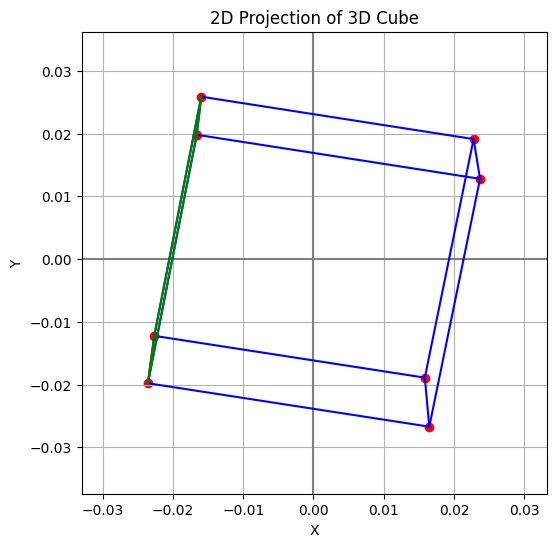

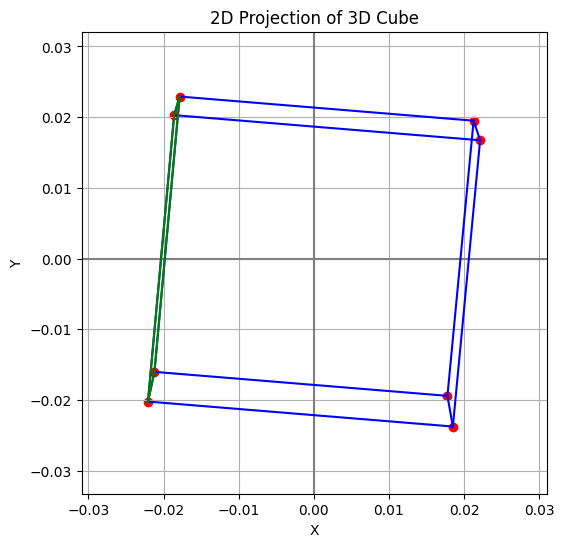

In [10]:
from matplotlib import animation
from celluloid import Camera

fig = plt.figure()
camera = Camera(fig)

plots = []
for x,y in zip(range(0, 90, 5), range(0, 90, 5)):
    projected_points = perspective_projection_3d_to_2d(
        points_in_3D = corners_3d, 
        focal_length = 1.0,
        rotation_xyz = [x, y, 0.], 
        transpose_xyz = [0., 0., 50.], 
        camera_offset_xy = [0., 0.]
    )
    plot_matrix(projected_points)
    camera.snap()

animation = camera.animate()

animation.save(
    'box_rotation.mp4',
    dpi=100,
)